Libraries

In [1]:
# System
import os

# Data Processing
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import randint

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


# Plot
import matplotlib.pyplot as plt

In [2]:
path_fault_v1 = "/mnt/c/Users/rafae/OneDrive/Documentos/Projects/TE - Cable Fault Localization/Data/V1_Fault_Voltages/"

In [3]:
fault_pos_len = 100
fault_imp_len = 3
n_sections = 20
fft_size = [1024]

Ts = 10e-6
time_len = 500

Q = 5 # Decimation factor

Ts_f = Q*Ts
time_len_f = int(time_len/Q)

time = Ts_f*np.linspace(0,time_len_f, time_len_f, endpoint=False)

fault_v1 = np.zeros((n_sections * fault_pos_len * fault_imp_len, time_len, 1))

fault_sec_label = np.zeros((n_sections * fault_pos_len * fault_imp_len))
fault_pos_label = np.zeros((n_sections * fault_pos_len * fault_imp_len))
fault_imp_label = np.zeros((n_sections * fault_pos_len * fault_imp_len))

In [4]:
idx_file = 0

os.chdir(path_fault_v1)

with os.scandir(path_fault_v1) as files_list:
    for file_name in files_list:
        print(file_name.name)
        
        df = pd.read_hdf(file_name.name)

        new_file_name = file_name.name.replace(".h5","")
        file_name_split = new_file_name.split("_")
        
        fault_v1[idx_file,:] = df.to_numpy()[:-1,:]
        
        fault_sec_label[idx_file] = float(file_name_split[2])
        fault_pos_label[idx_file] = float(file_name_split[4])
        fault_imp_label[idx_file] = float(file_name_split[6])

        idx_file += 1

V1_Section_01_Position_0.1070_Rfault_1017.4291.h5
V1_Section_01_Position_0.1070_Rfault_6.8056.h5
V1_Section_01_Position_0.1070_Rfault_98.2894.h5
V1_Section_01_Position_0.1756_Rfault_1041.6356.h5
V1_Section_01_Position_0.1756_Rfault_7.6928.h5
V1_Section_01_Position_0.1756_Rfault_96.6714.h5
V1_Section_01_Position_0.2296_Rfault_1076.9789.h5
V1_Section_01_Position_0.2296_Rfault_4.6587.h5
V1_Section_01_Position_0.2296_Rfault_94.0454.h5
V1_Section_01_Position_0.2358_Rfault_1030.6432.h5
V1_Section_01_Position_0.2358_Rfault_113.7178.h5
V1_Section_01_Position_0.2358_Rfault_4.9450.h5
V1_Section_01_Position_0.2617_Rfault_4.7825.h5
V1_Section_01_Position_0.2617_Rfault_74.9038.h5
V1_Section_01_Position_0.2617_Rfault_802.8868.h5
V1_Section_01_Position_0.2720_Rfault_112.6981.h5
V1_Section_01_Position_0.2720_Rfault_5.1880.h5
V1_Section_01_Position_0.2720_Rfault_917.5229.h5
V1_Section_01_Position_0.2746_Rfault_107.1154.h5
V1_Section_01_Position_0.2746_Rfault_1094.0998.h5
V1_Section_01_Position_0.2746_R

In [5]:
fault_v4 = 75 - fault_v1

fault_v4_mean = fault_v4.mean(axis = 1)

fault_v4_meanless = fault_v4 - fault_v4_mean[:, np.newaxis]

fault_v4_norm = preprocessing.normalize(fault_v4_meanless[:,:,0])

In [7]:
fault_v4_dec = sp.signal.decimate(fault_v4_norm, Q, axis=1)

fault_v4_fft = {} 
feature_v4_norm = {}

for i in range(len(fft_size)):
            
    fault_v4_fft[i] = np.fft.fft(fault_v4_dec, fft_size[i], 1, "ortho")

    feature_v4 = abs(fault_v4_fft[i][:,int(fft_size[i]/2):])

    feature_v4_mean = feature_v4.mean(axis = 1)

    feature_v4_meanless = feature_v4 - feature_v4_mean[:,np.newaxis]

    feature_v4_norm[i] = preprocessing.normalize(feature_v4_meanless)

128

The best hyperparameters are: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}

0.9814583333333333

256

The best hyperparameters are: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}

0.973125

1024

The best hyperparameters are: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}

0.9766666666666667

In [8]:
seed = 26

y_test = np.zeros((int(0.2 * n_sections * fault_pos_len * fault_imp_len),len(fft_size)))
y_pred_test = np.zeros((int(0.2 * n_sections * fault_pos_len * fault_imp_len),len(fft_size)))

tune_mlp = True

hidden_layer_sizes = (50,)
activation = "relu"
solver = "adam"
alpha = 0.0001

for i in range(len(fft_size)):

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test[:,i] = train_test_split(feature_v4_norm[i], fault_sec_label, test_size=0.2, random_state= seed)
    
    if tune_mlp:
        # Define the parameter grid to search
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
        }

        # Create an MLP classifier
        mlp = MLPClassifier(max_iter=2000)

        # Create a GridSearchCV object
        grid_search = GridSearchCV(mlp, param_grid, cv=5)

        # Fit the GridSearchCV object to the data
        grid_search.fit(X_train, y_train)

        # Create a variable for the best model
        best_mlp = grid_search.best_estimator_

        # Print the best hyperparameters found
        print(f"The best hyperparameters are: {grid_search.best_params_}")
    else:
        # Create an MLP classifier
        best_mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, max_iter=2000)

        # Train MLP
        best_mlp.fit(X_train, y_train)
        
    y_pred_train = best_mlp.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    print(accuracy_train)

    y_pred_test[:,i] = best_mlp.predict(X_test) # Predict the labels of the test data with MLP

The best hyperparameters are: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
0.9766666666666667


128

MLP
Accuracy: 0.9833333333333333

256

MLP
Accuracy: 0.9708333333333333

1024

MLP
Accuracy: 0.9775

In [9]:
for i in range(len(fft_size)):
    accuracy_mlp = accuracy_score(y_test[:,i], y_pred_test[:,i])

    print("MLP")
    print("Accuracy:", accuracy_mlp)

MLP
Accuracy: 0.9775


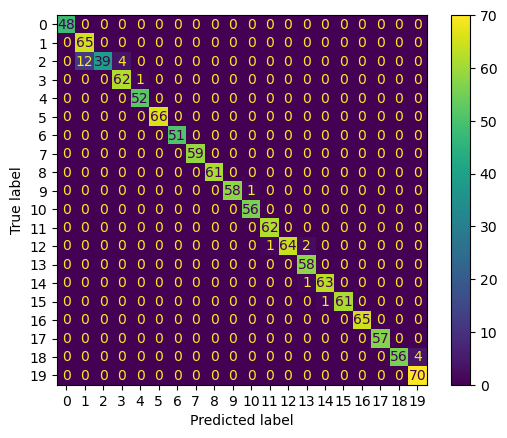

In [10]:
for i in range(len(fft_size)):
    cm_mlp = confusion_matrix(y_test[:,i], y_pred_test[:,i])

    ConfusionMatrixDisplay(confusion_matrix=cm_mlp).plot()

Debug Section

In [30]:
print(len(X_test))

1200
